# Shark Attacks Project

### HIPOTESIS

RESUMEN DEL ANALISIS

In [1]:
import pandas as pd
import numpy as np
import re
import calendar
import scr.Fun as f
import matplotlib.pyplot as plt

- Creación del DataFrame. Es necesario utilizar la codificación como latin1 ya que el archivo contiene caracteres especiales.

In [2]:
df = pd.read_csv('INPUT/GSAF5.csv', encoding = 'latin1')

- Configuración para poder ver todas las filas y columnas para una mejor exploración de los datos que dispongo y pensar cómo puedo limpiarlos.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### PASO 1: Inspección y descarte de datos.

In [4]:
df.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

1. Observo algún error a corregir en el nombre de las columnas por incluir espacios.
2. A primera vista, parece que hay columnas con datos repetidos, como 'href formula' y 'href' o 'Case Number' y 'Case Number.1' y 'Case Number.2'.
3. Existen columnas cuyo nombre no nos dice mucho, que probablemente no contengan datos relevantes.

Seguidamente, compruebo la cantidad de datos que contiene el archivo y el porcentaje de datos nulos que hay por columna.

In [5]:
print('Number of Rows and Columns:', df.shape)

print('\nPercentage of nulls per column:\n\n',(df.isnull().sum()/5992)*100)

Number of Rows and Columns: (5992, 24)

Percentage of nulls per column:

 Case Number                0.000000
Date                       0.000000
Year                       0.000000
Type                       0.000000
Country                    0.717623
Area                       6.708945
Location                   8.277704
Activity                   8.795060
Name                       3.337784
Sex                        9.462617
Age                       44.742991
Injury                     0.450601
Fatal (Y/N)                0.317089
Time                      53.621495
Species                   48.965287
Investigator or Source     0.250334
pdf                        0.000000
href formula               0.016689
href                       0.050067
Case Number.1              0.000000
Case Number.2              0.000000
original order             0.000000
Unnamed: 22               99.983311
Unnamed: 23               99.966622
dtype: float64


1. Confirmo que las columnas 'Unnamed' están prácticamente vacías, por lo que podemos eliminarlas.
2. Las columnas 'Species', 'Time' y 'Age' tienen un alto volumen de celdas vacías, por tanto, dificulta su análisis y no las tendremos en cuenta.

Ahora comprobamos si las columnas 'Case Number' y 'href' contienen los mismos datos:

In [6]:
def check_dupl_caseNumber(col):
    index = 0
    for value in col:
        if value == df['Case Number.1'][index] and value == df['Case Number.2'][index]:
            index += 1
            return True
        else:
            index += 1
            return False

print(check_dupl_caseNumber(df['Case Number']))

def check_dupl_href(col):
    index = 0
    for value in col:
        if value == df['href formula'][index]:
            index += 1
            return True
        else:
            index += 1
            return False

print(check_dupl_href(df['href']))

True
True


Concluyo que las columnas 'Case Number.1' y 'Case Number.2' contienen los mismos datos que la columna 'Case Number', por lo que se puede eliminar dichas dos. 
Además, la columna 'href' también contiene los mismos datos que 'href formula' e incluso tiene más vacías, por tanto, se puede deshechar.

In [7]:
drop_cols = ['Unnamed: 22', 'Unnamed: 23', 'Case Number.1', 'Case Number.2', 'href']

df = df.drop(drop_cols, axis=1)

cols_analysis = ['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 
                 'Sex ', 'Injury', 'Fatal (Y/N)', 'Investigator or Source', 'pdf', 'href formula',
                 'original order']

df1 = df.loc[:,cols_analysis]

df1.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Injury', 'Fatal (Y/N)',
       'Investigator or Source', 'pdf', 'href formula', 'original order'],
      dtype='object')

En este momento, he ido mirando los datos que contiene cada columna para identificar dificultad de limpieza, utilidad y veracidad.

- Case Number: contiene el número del caso registrado, que incluye la fecha y alguna letra. La utilidad que le voy a dar es para crear una nueva columna llamada 'Month' y poder sacar el mes en el que se dio el incidente.

- Date: contiene la fecha del incidente pero no sigue un formato determinado. Difícil de limpiar y repite datos que tenemos en la columna 'Case Number'. Descarto del análisis.

- Year: contiene el año del incidente. Bastante unificado y completo.

- Type: especifica si el ataque fue provocado o no. Me parece un dato inconsistente ya que no se en qué se han basado para categorizar como provocación un ataque. Si comparo con las actividades realizadas durante el ataque, el surf se considera tanto en provocado como no provocado, al igual que el nado o la pesca. Descarto del análisis.

- Country: especifica el país donde se ha dado el ataque. Contiene pocos datos nulos y parece consistente.

- Area: especifica la ciudad/estado en el que ha surgido el ataque. Me basaré en el país del incidente, por tanto, descarto del análisis.

- Location: especifica la playa donde se ha dado el ataque. Contiene muy pocos datos agrupados. Me basaré en el país del incidente, por tanto, descarto del análisis.

- Activity: especifica la actividad que realizaba la víctima en el momento del ataque. Los datos están muy dispersos y hay que reagruparlos bajo una misma categoría.

- Name: se pretende identificar el nombre de la víctima pero la gran mayoría están sin especificar. No nos interesa para el análisis.

- Sex: determina el sexo de la víctima. Casi un 10% de los datos son nulos, lo que considero demasiado para tener en cuenta en el análisis.

- Injury: especifica en qué parte del cuerpo fue el ataque. Datos muy dispersos que hay que reagrupar bajo una misma categoría.

- Fatal: identifica si el ataque fue mortal o tuvo consecuencias graves para la víctima (o eso entiendo yo). Como la interpretación es ambigua y, además, la categoría fatal también aparece en la columna de 'Injury', lo descarto del análisis.

- Investigator or Source: especifica la fuente. Está muy atomizado y no necesito esta información para la hipótesis, por tanto, descarto del análisis.

- pdf y href formula: uno contiene los enlaces completos al pdf del caso, y el otro contiene solo el nombre del pdf. Al no necesitarlo para el análisis, lo descarto.

- Original order: no se a qué hacen referencia los números aportados, por lo que, descarto del análisis.

In [8]:
cols_analysis = ['Case Number', 'Year', 'Country', 'Activity', 'Injury']

attacks = df.loc[:,cols_analysis]

attacks.columns

Index(['Case Number', 'Year', 'Country', 'Activity', 'Injury'], dtype='object')

### PASO 2: Limpieza de datos

#### COLUMNA MONTH

Creo una columna con el mes en el que ha surgido el ataque, en base a la columna 'Case Number'.

In [9]:
# Extraigo el mes de la columna 'Case Number':

attacks['Month'] = attacks['Case Number'].str.extract('(\.\d{2}\.)')

# Elimino los dos puntos que se han extraido:

attacks['Month'] = attacks['Month'].str.extract('(\d{2})')

# En algunos casos, el 'Case Number' no indica el mes por falta de información. Sustituyo los valores nulos por 0:

attacks.Month = attacks.Month.fillna(0).astype('int')

# Cambio los valores extraidos por el nombre del mes correspondiente:

for x in range(1,13):
    
    attacks.loc[attacks['Month'] == x, 'Month'] = calendar.month_name[x]
    attacks.loc[attacks['Month'] == 30, 'Month'] = 'August'

# Los valores nulos sustituidos por 0, los identifico como 'Unknown'. Suponen un 6.4% sobre el total:

attacks.loc[attacks['Month'] == 0, 'Month'] = 'Unknown'

Compruebo el peso que tiene cada mes sobre el total de registros para comprobar que los nulos no suponen un porcentaje muy elevado. En este momento supone un 8.7%, sin embargo, a lo largo del análisis este porcentaje bajará hasta el 6.4% debido a la omisión de algunos de los datos que considero a descartar.

In [10]:
print(attacks.shape)

print((attacks.Month.value_counts()/5992)*100)

(5992, 6)
July         10.564085
August        9.679573
September     8.744993
Unknown       8.728304
January       8.344459
June          7.910547
December      7.059413
April         6.842457
October       6.792390
March         6.642190
November      6.558745
May           6.141522
February      5.991322
Name: Month, dtype: float64


In [11]:
order = ['Case Number', 'Month', 'Year', 'Country', 'Activity', 'Injury']

attacks = attacks.loc[:,order]

attacks.head()

,Case Number,Month,Year,Country,Activity,Injury
0,2016.09.18.c,September,2016,USA,Surfing,Minor injury to thigh
1,2016.09.18.b,September,2016,USA,Surfing,Lacerations to hands
2,2016.09.18.a,September,2016,USA,Surfing,Lacerations to lower leg
3,2016.09.17,September,2016,AUSTRALIA,Surfing,Struck by fin on chest & leg
4,2016.09.15,September,2016,AUSTRALIA,Surfing,No injury: Knocked off board by shark


#### COLUMNA YEAR

Elimino de la tabla valores anteriores al año 1800, ya que debido a su antiguedad son poco consistentes, ofrecían poca información en las columnas restantes, al igual que los años con valor 0. Con ello también eliminamos datos errónes que teníamos al final de la serie.

In [12]:
# Compruebo los valores únicos de la columna:

display(attacks["Year"].unique())

# Decido no tener en cuenta los datos anteriores al año 1800 por prudencia.

attacks = attacks[attacks["Year"] >= 1800]

array([2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995,
       1984, 1994, 1993, 1992, 1991, 1990, 1989, 1969, 1988, 1987, 1986,
       1985, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974,
       1973, 1972, 1971, 1970, 1968, 1967, 1966, 1965, 1964, 1963, 1962,
       1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951,
       1950, 1949, 1948, 1848, 1947, 1946, 1945, 1944, 1943, 1942, 1941,
       1940, 1939, 1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930,
       1929, 1928, 1927, 1926, 1925, 1924, 1923, 1922, 1921, 1920, 1919,
       1918, 1917, 1916, 1915, 1914, 1913, 1912, 1911, 1910, 1909, 1908,
       1907, 1906, 1905, 1904, 1903, 1902, 1901, 1900, 1899, 1898, 1897,
       1896, 1895, 1894, 1893, 1892, 1891, 1890, 1889, 1888, 1887, 1886,
       1885, 1884, 1883, 1882, 1881, 1880, 1879, 1878, 1877, 1876, 1875,
       1874, 1873, 1872, 1871, 1870, 1869, 1868, 18

#### COLUMNA COUNTRY

Adapto los nombres a un formato correcto y, tanto los nulos como los que no aparecen más de 10 veces en el DataFrame, los categorizo como 'Otros' para reducir la atomización de datos.

In [13]:
# Hay 35 celdas vacías que categorizo como 'Otros':

attacks.Country = attacks.Country.fillna('OTHER')

# Adapto los nombres a mayúsculas y quito los espacios que contengan:

attacks['Country'] = attacks['Country'].str.upper()

def first_space(serie):
    return serie.replace("^\s", "")

attacks['Country'] = first_space(attacks['Country'].str)

# Mantengo los nombres de los países que se repiten más de 10 veces:

attacks_country = attacks['Country'].value_counts()
attacks_country = attacks_country[attacks_country >= 10]

# El resto, los agrupo como 'Otros', lo que supone un 7,6% del total:

ind = attacks_country.index.tolist()

countries = []

for i in range(len(attacks.index)):
    if attacks.loc[i,'Country'] in ind:
        countries.append(attacks.loc[i,'Country'])
    else:
        countries.append('OTHER')
        
attacks["Country"] = countries

In [14]:
print(attacks.shape)

print((attacks.Country.value_counts()/5833)*100)

(5833, 6)
USA                     35.933482
AUSTRALIA               21.601234
SOUTH AFRICA             9.549117
OTHER                    7.663295
PAPUA NEW GUINEA         2.211555
NEW ZEALAND              2.125836
BRAZIL                   1.748671
BAHAMAS                  1.628664
MEXICO                   1.371507
ITALY                    1.148637
FIJI                     1.062918
PHILIPPINES              1.028630
REUNION                  0.942911
NEW CALEDONIA            0.874336
MOZAMBIQUE               0.720041
CUBA                     0.685753
SPAIN                    0.651466
EGYPT                    0.617178
CROATIA                  0.582890
INDIA                    0.548603
JAPAN                    0.548603
PANAMA                   0.497171
SOLOMON ISLANDS          0.462884
IRAN                     0.428596
HONG KONG                0.411452
JAMAICA                  0.394308
FRENCH POLYNESIA         0.360021
GREECE                   0.325733
INDONESIA                0.325733
ENGL

#### COLUMNA ACTIVITY

Esta columna, al ser descriptiva, contiene muchos datos que describen una misma actividad, por tanto, es necesario unificar bajo una misma categoría. Llegado a un punto donde las datos se dispersan mucho, los englobo bajo un mismo concepto de 'Otros', que suponen solo el 6.44% total de datos saneados.

In [15]:
# Hay 497 celdas vacías que categorizo como 'Desconocido':

attacks.Activity = attacks.Activity.fillna('Unknown')

# Agrupo actividades afines bajo un mismo nombre:

attacks.loc[attacks['Activity'].str.contains('surf', case=False), 'Activity'] = 'Surfing'

attacks.loc[attacks['Activity'].str.contains('swim', case=False)|
            attacks['Activity'].str.contains('bath', case=False)|
            attacks['Activity'].str.contains('float', case=False)|
            attacks['Activity'].str.contains('water', case=False)|
            attacks['Activity'].str.contains('splash', case=False), 'Activity'] = 'Swimming'


attacks.loc[attacks['Activity'].str.contains('fish', case=False)|
            attacks['Activity'].str.contains('crab', case=False)|
            attacks['Activity'].str.contains('clam', case=False)|
            attacks['Activity'].str.contains('kill', case=False)|
            attacks['Activity'].str.contains('hunt', case=False)|
            attacks['Activity'].str.contains('catch', case=False)|
            attacks['Activity'].str.contains('shoot', case=False), 'Activity'] = 'Fishing'

attacks.loc[attacks['Activity'].str.contains('div', case=False)|
            attacks['Activity'].str.contains('snork', case=False), 'Activity'] = 'Diving'

attacks.loc[attacks['Activity'].str.contains('wad', case=False)|
            attacks['Activity'].str.contains('stand', case=False)|
            attacks['Activity'].str.contains('walk', case=False)|
            attacks['Activity'].str.contains('tread', case=False)|
            attacks['Activity'].str.contains('wash', case=False)|
            attacks['Activity'].str.contains('sit', case=False)|
            attacks['Activity'].str.contains('play', case=False), 'Activity'] = 'Shore'

attacks.loc[attacks['Activity'].str.contains('kayak', case=False)|
            attacks['Activity'].str.contains('board', case=False)|
            attacks['Activity'].str.contains('row', case=False)|
            attacks['Activity'].str.contains('canoe', case=False)|
            attacks['Activity'].str.contains('sail', case=False)|
            attacks['Activity'].str.contains('boat', case=False)|
            attacks['Activity'].str.contains('paddl', case=False)|
            attacks['Activity'].str.contains('fell', case=False), 'Activity'] = 'Water sports'

# Mantengo las actividades que se repitan más de 10 veces:

attacks_activities = attacks['Activity'].value_counts()
attacks_activities = attacks_activities[attacks_activities >= 10]

# El resto, los agrupo como Otros, suponen un 6.44% del total:

ind = attacks_activities.index.tolist()

activities = []

for i in range(len(attacks.index)):
    if attacks.loc[i,'Activity'] in ind:
        activities.append(attacks.loc[i,'Activity'])
    else:
        activities.append('OTHER')

attacks["Activity"] = activities

In [16]:
print(attacks.shape)

print((attacks.Activity.value_counts()/5833)*100)

(5833, 6)
Swimming        24.224241
Surfing         20.264015
Fishing         19.183953
Diving           9.051946
Unknown          8.571918
Water sports     6.617521
OTHER            6.566089
Shore            5.520315
Name: Activity, dtype: float64


#### COLUMNA INJURY

Mismo caso que el anterior, con la diferencia de que agrupo según la parte del cuerpo que haya sido afectada por el ataque del tiburón. Llegado a un punto donde las datos se dispersan mucho, los englobo bajo un mismo concepto de 'Otros', que suponen solo el 6.5% del total de datos saneados.

In [17]:
# Hay 20 celdas vacías que categorizo como 'Desconocido':

attacks.Injury = attacks.Injury.fillna('Unknown')

# Agrupo los daños sufridos según la parte del cuerpo afectada:

attacks.loc[attacks['Injury'].str.contains('foot', case=False)|
            attacks['Injury'].str.contains('leg', case=False)|
            attacks['Injury'].str.contains('thigh', case=False)|
            attacks['Injury'].str.contains('calf', case=False)|
            attacks['Injury'].str.contains('ankle', case=False)|
            attacks['Injury'].str.contains('heel', case=False)|
            attacks['Injury'].str.contains('toe', case=False)|
            attacks['Injury'].str.contains('shin', case=False)|
            attacks['Injury'].str.contains('feet', case=False)|
            attacks['Injury'].str.contains('knee', case=False), 'Injury'] = 'Leg'

attacks.loc[attacks['Injury'].str.contains('hand', case=False)|
            attacks['Injury'].str.contains('arm', case=False)|
            attacks['Injury'].str.contains('finger', case=False)|
            attacks['Injury'].str.contains('shoul', case=False)|
            attacks['Injury'].str.contains('wrist', case=False)|
            attacks['Injury'].str.contains('elbo', case=False), 'Injury'] = 'Arm'

attacks.loc[attacks['Injury'].str.contains('torso', case=False)|
            attacks['Injury'].str.contains('hip', case=False)|
            attacks['Injury'].str.contains('chest', case=False)|
            attacks['Injury'].str.contains('butt', case=False)|
            attacks['Injury'].str.contains('back', case=False)|
            attacks['Injury'].str.contains('abdom', case=False), 'Injury'] = 'Trunk'

attacks.loc[attacks['Injury'].str.contains('no injury', case=False)|
            attacks['Injury'].str.contains('minor', case=False)|
            attacks['Injury'].str.contains('fin', case=False)|
            attacks['Injury'].str.contains('lacer', case=False), 'Injury'] = 'No injury'

attacks.loc[attacks['Injury'].str.contains('fatal', case=False)|
            attacks['Injury'].str.contains('drow', case=False), 'Injury'] = 'FATAL'

attacks.loc[attacks['Injury'].str.contains('survi', case=False)|
            attacks['Injury'].str.contains('detail', case=False), 'Injury'] = 'Unknown'

# Mantengo los ataques que se repiten más de 10 veces:

attacks_injuries = attacks['Injury'].value_counts()

attacks_injuries = attacks_injuries[attacks_injuries >= 10]

# El resto, los agrupo como Otros, suponen un 6.5% del total:

ind = attacks_injuries.index.tolist()

injuries = []

for i in range(len(attacks.index)):
    if attacks.loc[i,'Injury'] in ind:
        injuries.append(attacks.loc[i,'Injury'])
    else:
        injuries.append('OTHER')

attacks["Injury"] = injuries

In [18]:
print(attacks.shape)

print((attacks.Injury.value_counts()/5833)*100)

(5833, 6)
Leg          41.625236
FATAL        16.955255
Arm          14.726556
No injury    14.023658
OTHER         6.514658
Unknown       3.497343
Trunk         2.657295
Name: Injury, dtype: float64


### PASO 3: Análisis

In [19]:
attacks.head()

,Case Number,Month,Year,Country,Activity,Injury
0,2016.09.18.c,September,2016,USA,Surfing,Leg
1,2016.09.18.b,September,2016,USA,Surfing,Arm
2,2016.09.18.a,September,2016,USA,Surfing,Leg
3,2016.09.17,September,2016,AUSTRALIA,Surfing,Leg
4,2016.09.15,September,2016,AUSTRALIA,Surfing,No injury


nº de ataques por rango de año.

En la siguiente gráfico podemos ver el registro del número de ataques de tiburón que se han dado según el mes del año. Como podemos observar, la mayor parte de los casos se dan en los meses de julio, agosto y septiembre, aunque no hay una clara evidencia de ser los meses más representativos. PUEDE SER POR LAS DIFERENTES EPOCAS DEL AÑO SEGUN EL CONTINENTE.

Text(0.5, 1.0, 'Historical Shark Attacks by Month')

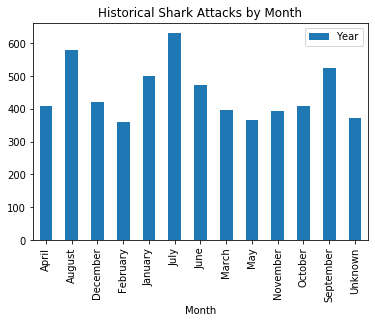

In [20]:
attacks.groupby('Month').agg({'Year':'count'}).plot.bar()

# AVERIGUAR COMO PUEDO ORDENAR POR MES SEGUN CALENDARIO, NO ALFABETICAMENTE.

plt.title('Historical Shark Attacks by Month')

La gran mayoría de los ataques de tiburón surgen en USA y Australia.

Text(0.5, 1.0, 'Historical Shark Attacks by Country')

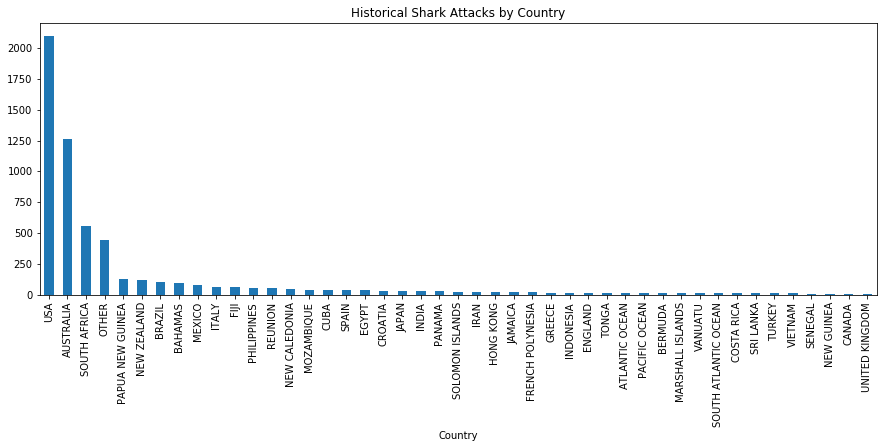

In [21]:
attacks.groupby('Country').Year.count().sort_values(ascending=False).plot.bar(figsize=(15,5))

plt.title('Historical Shark Attacks by Country')

La razón principal del ataque de tiburón en USA es el nado y el surf, seguido de la pesca.

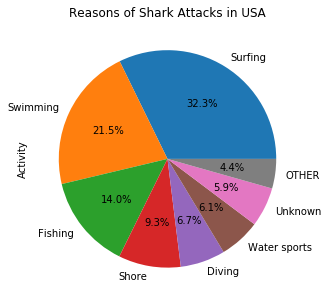

In [22]:
def pie_country_act(country):
    filt = attacks[attacks['Country'] == country]
    activ = filt.groupby('Activity').Activity.count().sort_values(ascending=False)
    plt.title(f'Reasons of Shark Attacks in {country}')
    return activ.plot.pie(figsize=(5,5), autopct='%1.1f%%')

display(pie_country_act('USA'))

El ataque de tiburón en USA es principalmente a las extremidades, sobre todo en piernas. Siendo la causa principal el nado y el surf, son las partes más vulnerables a un ataque.

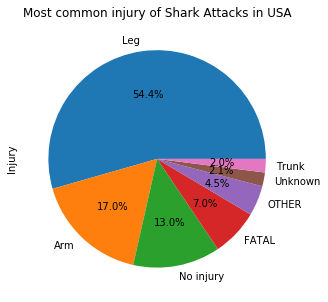

In [23]:
def pie_country_inj(country):
    filt = attacks[attacks['Country'] == country]
    activ = filt.groupby('Injury').Injury.count().sort_values(ascending=False)
    plt.title(f'Most Common Injuries of Shark Attacks in {country}')
    return activ.plot.pie(figsize=(5,5), autopct='%1.1f%%')

display(pie_country_inj('USA'))

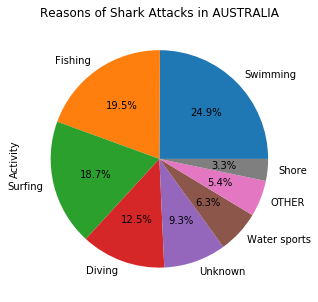

In [24]:
def pie_country_act(country):
    filt = attacks[attacks['Country'] == country]
    activ = filt.groupby('Activity').Activity.count().sort_values(ascending=False)
    plt.title(f'Reasons of Shark Attacks in {country}')
    return activ.plot.pie(figsize=(5,5), autopct='%1.1f%%')

display(pie_country_act('AUSTRALIA'))

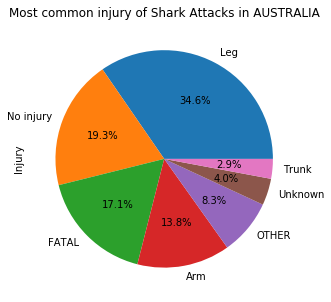

In [25]:
def pie_country_inj(country):
    filt = attacks[attacks['Country'] == country]
    activ = filt.groupby('Injury').Injury.count().sort_values(ascending=False)
    plt.title(f'Most Common Injury of Shark Attacks in {country}')
    return activ.plot.pie(figsize=(5,5), autopct='%1.1f%%')

display(pie_country_inj('AUSTRALIA'))